Found 5 structures.


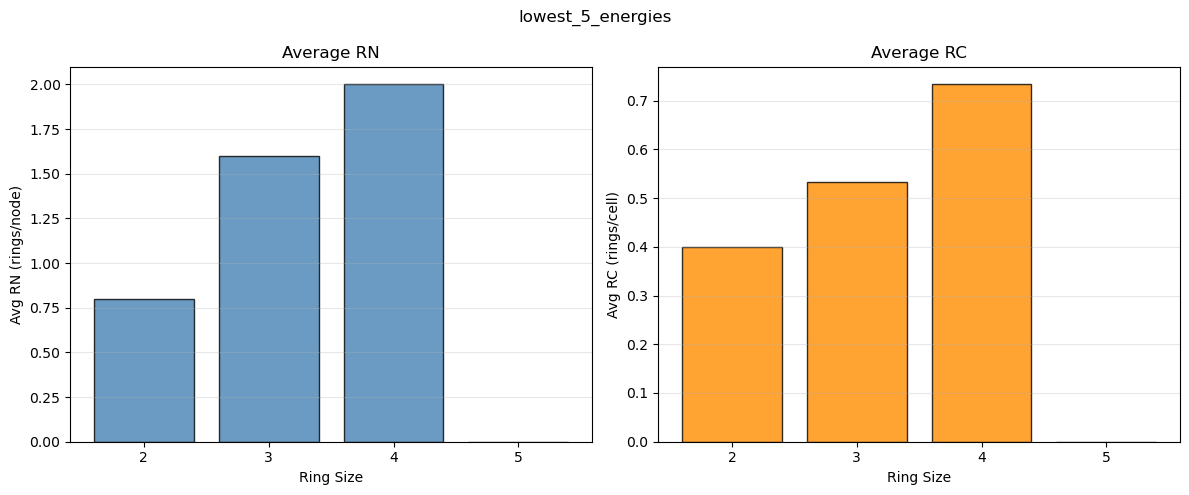

In [2]:
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pymatgen.core import Structure
from src.rings import calculate_ring_statistics_for_structure

# ── CONFIG ──────────────────────────────────────────────────────────
folder = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/50_structures_glass/sample_to_calculate_18/lowest_5_energies"   # <-- change this
max_ring_size = 20
# ────────────────────────────────────────────────────────────────────

poscar_files = sorted([
    f for f in glob.glob(os.path.join(folder, "POSCAR*")) + glob.glob(os.path.join(folder, "CONTCAR*"))
    if not f.endswith(".png")
])
print(f"Found {len(poscar_files)} structures.")

all_rn = defaultdict(list)
all_rc = defaultdict(list)

for f in poscar_files:
    try:
        struct = Structure.from_file(f)
        stats = calculate_ring_statistics_for_structure(struct, max_ring_size=max_ring_size)
        for size in range(2, max_ring_size + 1):
            all_rn[size].append(stats['RN'].get(size, 0.0))
            all_rc[size].append(stats['RC'].get(size, 0.0))
    except Exception as e:
        print(f"  Failed: {os.path.basename(f)} — {e}")

ring_sizes = range(2, max_ring_size + 1)
avg_rn = {s: np.mean(all_rn[s]) for s in ring_sizes}
avg_rc = {s: np.mean(all_rc[s]) for s in ring_sizes}

# Trim to non-zero range
nonzero = [s for s in ring_sizes if avg_rn[s] > 0]
plot_sizes = list(range(max(2, min(nonzero) - 1), min(max_ring_size, max(nonzero) + 2))) if nonzero else list(ring_sizes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(plot_sizes, [avg_rn[s] for s in plot_sizes], color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set(xlabel='Ring Size', ylabel='Avg RN (rings/node)', title='Average RN', xticks=plot_sizes)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(plot_sizes, [avg_rc[s] for s in plot_sizes], color='darkorange', edgecolor='black', alpha=0.8)
axes[1].set(xlabel='Ring Size', ylabel='Avg RC (rings/cell)', title='Average RC', xticks=plot_sizes)
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle(os.path.basename(folder.rstrip('/')))
plt.tight_layout()
plt.show()

Found 50 structures.
Total Si-O-Si angles collected: 613
Mean: 136.00°  Std: 20.53°


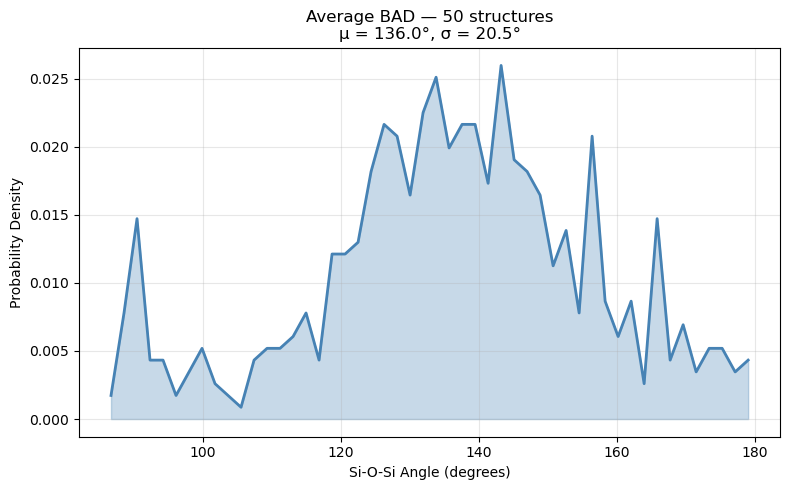

In [5]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure

# ── CONFIG ──────────────────────────────────────────────────────────
folder = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/50_structures_glass/sample_to_calculate_18"   # <-- change this
cutoff_si_o = 2.0
bins = 50
# ────────────────────────────────────────────────────────────────────

poscar_files = sorted([
    f for f in glob.glob(os.path.join(folder, "POSCAR*")) + glob.glob(os.path.join(folder, "CONTCAR*"))
    if not f.endswith(".png")
])
print(f"Found {len(poscar_files)} structures.")

all_angles = []

for f in poscar_files:
    try:
        struct = Structure.from_file(f)
        # Get all O-Si-O and Si-O-Si angles (Si-O-Si is standard for SiO2 BAD)
        for i, site in enumerate(struct):
            if site.species_string != 'O':
                continue
            # Find Si neighbors of this O
            si_neighbors = [n for n in struct.get_neighbors(site, cutoff_si_o)
                            if n.species_string == 'Si']
            if len(si_neighbors) < 2:
                continue
            # All Si-O-Si angles
            for a in range(len(si_neighbors)):
                for b in range(a + 1, len(si_neighbors)):
                    v1 = si_neighbors[a].coords - site.coords
                    v2 = si_neighbors[b].coords - site.coords
                    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                    cos_angle = np.clip(cos_angle, -1, 1)
                    all_angles.append(np.degrees(np.arccos(cos_angle)))
    except Exception as e:
        print(f"  Failed: {os.path.basename(f)} — {e}")

all_angles = np.array(all_angles)
print(f"Total Si-O-Si angles collected: {len(all_angles)}")
print(f"Mean: {all_angles.mean():.2f}°  Std: {all_angles.std():.2f}°")

hist, edges = np.histogram(all_angles, bins=bins, density=True)
centers = (edges[:-1] + edges[1:]) / 2

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(centers, hist, color='steelblue', linewidth=2)
ax.fill_between(centers, hist, alpha=0.3, color='steelblue')
ax.set(xlabel='Si-O-Si Angle (degrees)', ylabel='Probability Density',
       title=f'Average BAD — {len(poscar_files)} structures\n'
             f'μ = {all_angles.mean():.1f}°, σ = {all_angles.std():.1f}°')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()